## Fundamental Analysis of the Aave DeFi Protocol

#### Prepare Data:

In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Pull the daily revenue data from the Aave API
r = requests.get("https://api.llama.fi/summary/fees/aave?dataType=dailyRevenue").json()

revenue_df = pd.DataFrame(r['totalDataChart'], columns=['date', 'revenue'])
revenue_df['date'] = pd.to_datetime(revenue_df['date'], unit='s')

# Pull fees and add them to the dataframe
r = requests.get("https://api.llama.fi/summary/fees/aave?dataType=dailyFees").json()
fees_df = pd.DataFrame(r['totalDataChart'], columns=['date', 'fees'])
fees_df['date'] = pd.to_datetime(fees_df['date'], unit='s')

df = revenue_df.merge(fees_df, on='date')

# Find the expenses as the difference between fees and revenue
# agg_df['expenses'] = agg_df['fees'] - agg_df['revenue']

# Add annual operational expenses (6.28m yearly operating expense split into days)
df['operating_expense'] = 6.28e6 / 365

df.head()


,date,revenue,fees,operating_expense
0,2020-12-04,2.432609,41.547445,17205.479452
1,2020-12-05,17.099272,170.255684,17205.479452
2,2020-12-06,39.508408,397.440849,17205.479452
3,2020-12-07,72.647110,704.584146,17205.479452
4,2020-12-08,110.749524,1123.100814,17205.479452


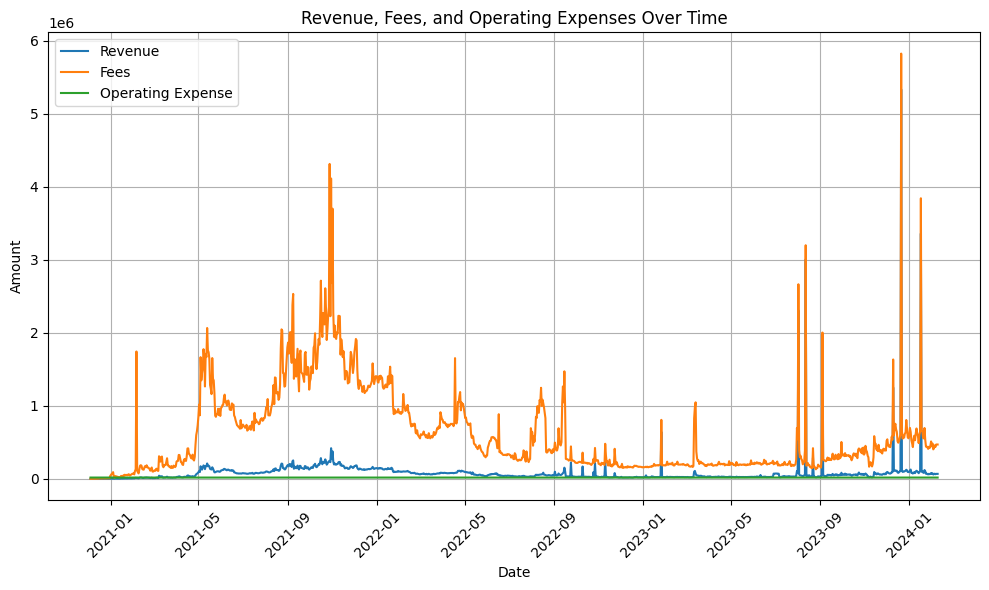

In [18]:
# Re-plotting without markers for a smoother line chart
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['revenue'], label='Revenue', linestyle='-')  # Smooth line for Revenue
plt.plot(df['date'], df['fees'], label='Fees', linestyle='-')  # Smooth line for Fees
plt.plot(df['date'], df['operating_expense'], label='Operating Expense', linestyle='-')  # Smooth line for Operating Expense

plt.title('Revenue, Fees, and Operating Expenses Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the adjusted plot
plt.show()


### Project Future Free Cash Flows (FFCF):

Assumptions:
* Operating costs stay the same (for simplicity)
* Revenue growth is predicted using a CAGR from it's historical data
    - Using years 2021-2024E
    - 2024E is extrapolated using the current daily average for 2024

In [19]:
# Find existing revenues by year
df['year'] = df['date'].dt.year
annual_revenue = df.groupby('year')['revenue'].sum().reset_index()

# Extrapolate the annual revenue for 2024
daily_revenue_2024 = df[df['year'] == 2024]['revenue']
average_daily_revenue_2024 = daily_revenue_2024.mean()

days_recorded_2024 = len(daily_revenue_2024)

estimated_full_year_revenue_2024 = average_daily_revenue_2024 * 365

annual_revenue.loc[annual_revenue['year'] == 2024, 'revenue'] = estimated_full_year_revenue_2024
annual_revenue['revenue_str'] = annual_revenue['revenue'].apply(lambda x: f"${x:,.2f}")
print("Realized Revenues:")
annual_revenue

Realized Revenues:


,year,revenue,revenue_str
0,2020,1.409311e+04,"$14,093.11"
1,2021,3.710478e+07,"$37,104,778.49"
2,2022,2.194632e+07,"$21,946,316.80"
3,2023,2.975274e+07,"$29,752,738.47"
4,2024,6.019432e+07,"$60,194,320.88"


In [20]:
# Calculate CAGR
start_year_revenue = annual_revenue.loc[annual_revenue['year'] == 2021, 'revenue'].values[0]
end_year_revenue = annual_revenue.loc[annual_revenue['year'] == 2024, 'revenue'].values[0]
number_of_years = 2024 - 2021  # This assumes your start year is 2021 and end year is 2024

cagr = ((end_year_revenue / start_year_revenue) ** (1 / number_of_years)) - 1

print(f"CAGR: {cagr * 100:.2f}%")

CAGR: 17.50%


In [21]:
# Forecast next 10 years of revenues using the calculated CAGR:
forecasted_revenues = [end_year_revenue]
for year in range(10):  # 1 through 10
    next_year_revenue = forecasted_revenues[-1] * (1 + cagr)  # Calculate next year's revenue
    forecasted_revenues.append(next_year_revenue)
    
forecast_years = list(range(2025, 2025+10))  # Years 2025 through 2034
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'revenue': forecasted_revenues[1:],  # Exclude the first element as it's the base year (2024)
    'revenue_str': [f"${revenue:,.2f}" for revenue in forecasted_revenues[1:]]
})
annual_revenue = pd.concat([annual_revenue, forecast_df], ignore_index=True)
print("Realized & Forecasted Revenues:")
annual_revenue

Realized & Forecasted Revenues:


,year,revenue,revenue_str
0,2020,1.409311e+04,"$14,093.11"
1,2021,3.710478e+07,"$37,104,778.49"
2,2022,2.194632e+07,"$21,946,316.80"
3,2023,2.975274e+07,"$29,752,738.47"
4,2024,6.019432e+07,"$60,194,320.88"
5,2025,7.072898e+07,"$70,728,982.59"
6,2026,8.310732e+07,"$83,107,324.83"
7,2027,9.765201e+07,"$97,652,011.77"
8,2028,1.147422e+08,"$114,742,177.33"
9,2029,1.348233e+08,"$134,823,307.99"


In [22]:
# Add free cash flow (FCF) to the dataframe (assuming constant operating costs)
YEAR_OPERATING_EXPENSES = 6.28e6  # Assumed constant sourced from DefiLlama
TAX_RATE = 0.25  # Corporate tax rate for London, UK where Aave is based

annual_revenue['FCF'] = (annual_revenue['revenue'] - YEAR_OPERATING_EXPENSES) * (1 - TAX_RATE)
annual_revenue['FCF_str'] = annual_revenue['FCF'].apply(lambda x: f"${x:,.2f}")
annual_revenue

,year,revenue,revenue_str,FCF,FCF_str
0,2020,1.409311e+04,"$14,093.11",-4.699430e+06,"$-4,699,430.17"
1,2021,3.710478e+07,"$37,104,778.49",2.311858e+07,"$23,118,583.87"
2,2022,2.194632e+07,"$21,946,316.80",1.174974e+07,"$11,749,737.60"
3,2023,2.975274e+07,"$29,752,738.47",1.760455e+07,"$17,604,553.85"
4,2024,6.019432e+07,"$60,194,320.88",4.043574e+07,"$40,435,740.66"
5,2025,7.072898e+07,"$70,728,982.59",4.833674e+07,"$48,336,736.94"
6,2026,8.310732e+07,"$83,107,324.83",5.762049e+07,"$57,620,493.62"
7,2027,9.765201e+07,"$97,652,011.77",6.852901e+07,"$68,529,008.83"
8,2028,1.147422e+08,"$114,742,177.33",8.134663e+07,"$81,346,633.00"
9,2029,1.348233e+08,"$134,823,307.99",9.640748e+07,"$96,407,480.99"


#### Compute Beta for Aave:

To compute the beta we will be using the S&P 500 as the market index and Aave's historical data as the stock. In a real-world scenario, it may be more relevant to use a cryptocurrency indices like the [CoinDesk Market Index (CMI)](https://www.coindesk.com/indices/cmi)

##### Beta Option A: SPY Returns as Benchmark

In [80]:
# Get the historical token prices for Aave and the historical share prices for SPY from yahoo finance
# Load the data
aave_df = pd.read_csv('data/AAVE-USD.csv')
spy_df = pd.read_csv('data/SPY.csv')

# Ensure the 'Date' column is in datetime format
aave_df['Date'] = pd.to_datetime(aave_df['Date'])
spy_df['Date'] = pd.to_datetime(spy_df['Date'])

# Calculate daily returns
aave_df['Returns'] = aave_df['Close'].pct_change()
spy_df['Returns'] = spy_df['Close'].pct_change()

# Merge the data on 'Date'
merged_df = pd.merge(aave_df[['Date', 'Returns']], spy_df[['Date', 'Returns']], on='Date', suffixes=('_aave', '_spy'))
merged_df.dropna(inplace=True)

merged_df.head()

,Date,Returns_aave,Returns_spy
1,2020-10-05,0.010331,0.017733
2,2020-10-06,-0.203266,-0.014216
3,2020-10-07,-0.054659,0.017407
4,2020-10-08,0.091819,0.008863
5,2020-10-09,0.069766,0.008930


In [81]:
import statsmodels.api as sm

# Perform regression analysis t ofind beta
X = merged_df['Returns_spy']
y = merged_df['Returns_aave']
X1 = sm.add_constant(X) # Adds a constant term to the predictor
model = sm.OLS(y, X1)
results = model.fit()

# The beta of AAVE relative to SPY is the slope coefficient (index 1 of params)
beta_aave = results.params[1]

print(f"Beta of AAVE relative to SPY: {beta_aave}")

Beta of AAVE relative to SPY: 2.019547888619746


/var/folders/q0/mx_mx32j7p10qkmd312s5n800000gn/T/ipykernel_61255/408841776.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_aave = results.params[1]


##### Beta Option B: BITW Crypto Index as Benchmark

In [27]:
## EXPLORATORY BETA CALCULATION OF BITW
import statsmodels.api as sm

# Get the historical token prices for Aave and the historical share prices for SPY from yahoo finance
# Load the data
aave_df = pd.read_csv('data/AAVE-USD.csv')
bitw_df = pd.read_csv('data/BITW_max.csv')

# Ensure the 'Date' column is in datetime format
aave_df['Date'] = pd.to_datetime(aave_df['Date'])
bitw_df['Date'] = pd.to_datetime(bitw_df['Date'])

# Calculate daily returns
aave_df['Returns'] = aave_df['Close'].pct_change()
bitw_df['Returns'] = bitw_df['Close'].pct_change()

# Merge the data on 'Date'
merged_df = pd.merge(aave_df[['Date', 'Returns']], bitw_df[['Date', 'Returns']], on='Date', suffixes=('_aave', '_bitw'))
merged_df.dropna(inplace=True)

# Perform regression analysis t ofind beta
X = merged_df['Returns_bitw']
y = merged_df['Returns_aave']
X1 = sm.add_constant(X) # Adds a constant term to the predictor
model = sm.OLS(y, X1)
results = model.fit()

# The beta of AAVE relative to SPY is the slope coefficient (index 1 of params)
beta_aave = results.params[1]

print(f"Beta of AAVE relative to BITW: {beta_aave}")

Beta of AAVE relative to BITW: 0.3047561943375672


/var/folders/q0/mx_mx32j7p10qkmd312s5n800000gn/T/ipykernel_69228/4091371073.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_aave = results.params[1]


#### Apply CAPM to Find the Discount Rate:

In finding the discount rate, we will use the following assumptions:

- The company is all-equity (no debt)
- The risk-free rate is assumed at 2%, referenced by [this document](https://docs.credmark.com/smart-money-in-defi/investment-concepts/minimum-risk-rate-of-defi#minimum-risk-rate-of-defi-1.0) discussing the "minimum risk rate" of DeFi. They have developed a "risk-free rate" for DeFi projects based on this model:

    ![risk model](docs/risk_model.png)

- To derive a market risk premium, I will be using the average yearly return of the [Bitwise 10 Crypto Index Fund (BITW)](https://bitwiseinvestments.com/crypto-funds/bitw) across the maximum time period available (2020-2024). The BITW Index provides a broad measure of the cryptocurrency market comprised of the top 10 tokens by market cap, and is a good proxy for the market risk premium for a cryptocurrency project.

In [28]:
# Calculate the market risk premium by getting the average yearly return from 2021-2023 from the BITW index
bitw_df = pd.read_csv('data/BITW_max.csv')
bitw_df['Date'] = pd.to_datetime(bitw_df['Date'])
bitw_df['Year'] = bitw_df['Date'].dt.year

# Calculate the start and end close price for each year
yearly_prices = bitw_df.groupby('Year')['Close'].agg(['first', 'last'])

# Calculate yearly returns: (end price / start price - 1) * 100
yearly_returns = ((yearly_prices['last'] / yearly_prices['first']) - 1) * 100

# Calculate the average yearly return
avg_market_return = yearly_returns.mean()

yearly_returns, avg_market_return

(Year
 2020     65.906582
 2021    -27.471476
 2022    -85.946087
 2023    314.874552
 2024     -3.990224
 dtype: float64,
 52.674669207501005)

In [29]:
risk_free_rate = 0.02
market_risk_premium = (avg_market_return / 100) - risk_free_rate

risk_free_rate, market_risk_premium, beta_aave

(0.02, 0.50674669207501, 0.3047561943375672)

In [30]:
# Calculate cost of equity given the risk free rate and market risk premium
cost_of_equity = risk_free_rate + (beta_aave * market_risk_premium)
cost_of_equity  # Discount rate

0.17443419336993105

#### Discount Free Cash Flows to Find the Value of Aave:

Using the discount rate derived from the CAPM, we can discount the future free cash flows to find the present value of Aave.

In choosing a continuous growth rate, I have chosen 5% as a conservative estimate. This is based on the fact that the typical selection at the upper-end of a long term growth rate in fundamental DCF analysis is 4%, but considering the strong returns of the protocol and the DeFi market, I have incremented this by 1%.

In [31]:
g = 0.05

future_cash_flows = annual_revenue[annual_revenue['year'] >= 2025]['FCF']

terminal_value = (future_cash_flows.iloc[-1] * (1 + g)) / (cost_of_equity - g)

# Calculate the present value of each FCF and the TV
discounted_fcfs = [fcf / ((1 + cost_of_equity) ** (year + 1)) for year, fcf in enumerate(future_cash_flows)]
PV_TV = terminal_value / ((1 + cost_of_equity) ** len(future_cash_flows))

# Sum up the present values to get the total value
total_value = sum(discounted_fcfs) + PV_TV

print("Total Value of Aave:", total_value)
print("Implied Token Value:", total_value / 14730095)

Total Value of Aave: 805947736.5935271
Implied Token Value: 54.714361081413735
